# Exercise 4

## Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
plt.rcParams['font.size'] = 14

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

import pandas as pd
from scipy import stats

import seaborn 
from sklearn import metrics

from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV


from tsfresh import extract_features
from xgboost import XGBClassifier, plot_tree

# For displaying progress
from tqdm import tqdm

## Creating models

In [51]:
L = 60
input_shape = (L, 1)
n_class = 3
BATCH_SIZE = 250
EPOCHS = 100


def create_CNNmodel(NCONV = 1,NF = 5,reg_type = 1,reg_lambda = 0.5,set_seed = True):

    if set_seed:
        # reproducibility
        np.random.seed(12345)
        import tensorflow.random as tf_r
        tf_r.set_seed(12345)

    ## from keras import regularizers, initializers
    if reg_type == 2:
        reg = tf.keras.regularizers.l2(reg_lambda) ## raised to 0.2

    elif reg_type == 1:
        reg = tf.keras.regularizers.l1(reg_lambda)

    ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, 
                                            seed=None)
    

    # challenge: at most 600 tunable parameters
    model = Sequential()
    # 
    
    if NCONV==1:
        # -----2-----
        model.add(Conv1D(filters=NF, kernel_size=11, 
                        kernel_initializer=ini, 
                        kernel_regularizer=reg,
                        activation='relu', 
                        input_shape=input_shape))
        #model.add(MaxPooling1D(3))
        model.add(AveragePooling1D(5))
        model.add(Conv1D(filters=5, kernel_size=7, 
                        activation='relu'))
        model.add(Flatten())
        model.add(Dense(12, activation='relu'))
        model.add(Dropout(0.2))
    # 
    if NCONV==2:
        # -----1-----
        model.add(Conv1D(filters=NF, kernel_size=11, 
                        kernel_initializer=ini, 
                        kernel_regularizer=reg, ######## TRY WITHOUT !
                        activation='relu', input_shape=input_shape))
        #model.add(MaxPooling1D(3))
        model.add(AveragePooling1D(5))
        model.add(Flatten())
        model.add(Dense(9, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(6, activation='relu'))
        model.add(Dropout(0.2))
        #model.add(Dense(10, activation='relu'))
        #model.add(Dropout(0.3))
    model.add(Dense(n_class, activation='softmax')) # softmax !

    # print('----- Model',NCONV,'-----')
    # print(model.summary())

    # optimizers
    # .SGD(lr=0.01, momentum=0.9, nesterov=True) # decay=1e-6,
    # .RMSprop()
    # .Nadam()
    opt = tf.keras.optimizers.Adam()

    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=opt,metrics=['accuracy'])
    
    return model

def create_XGTBoostmodel(*,
    set_seed = True,
    max_depth = 6,
    min_child_weight = 1,
    learning_rate = 0.3,
    use_label_encoder = False,
    eval_metric = "mlogloss",
    **kwargs
    ):
    
    if set_seed:
        np.random.seed(12345)

    #define parameters for xgboost
    params = {'max_depth':max_depth,'min_child_weight':min_child_weight,\
            'learning_rate' : learning_rate,'use_label_encoder':use_label_encoder, 
              'eval_metric' : eval_metric}

    #build model with given params
    model = XGBClassifier(
        max_depth = max_depth,
        min_child_weight = min_child_weight,
        learning_rate = learning_rate,
        use_label_encoder = use_label_encoder,
        eval_metric = eval_metric,
        **kwargs)
    return model

In [6]:
def load_data(filename):
    """
    Simply loads x-data and y-data for given filename
    """
    str0 = filename
    fnamex='DATA/x_'+str0
    fnamey='DATA/y_'+str0
    

    x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
    N,L = len(x), len(x[0])


    categ = np.loadtxt(fnamey, dtype=int)
    n_class = 3    # y.argmax() - y.argmin() +1
    # print('data: ',N)

    y = np.zeros((N,n_class))
    for i in range(N):
        y[i][categ[i]] = 1.

    # # rescaling stuff
    # xm = x.mean(axis=1)
    # for i in range(N):
    #     x[i] = x[i]-xm[i]
    
    # x = x/400

    return x,y

def Show_weights(model,ax1,ax2,l=0,label="model"):
    c=['r','y','c','b','m']
    m=['o','s','D','<','>']
    ms=10
    
    w = model.layers[l].get_weights()[0]
    wT=w.T
    M=len(wT)
    b = model.layers[l].get_weights()[1]
    
    ax1.axhline(0, c="k")
    ax1.plot((0,))
    for i in range(M):
        ax1.plot(wT[i][0],"-",c=c[i],marker=m[i],label=str(i),markersize=ms)
    ax1.set_title(label+': filters of layer '+str(l))
    ax1.set_xlabel('index')
    
    ax2.axhline(0, c="k")
    for i in range(M):
        ax2.plot((i),(b[i]),c=c[i],marker=m[i],label="filter "+str(i),markersize=ms)
    ax2.set_title(label+': bias of layer '+str(l))
    ax2.set_xlabel('filter nr')
    ax2.set_xticks(np.arange(5))
    ax2.legend()
    
def Show_history(fit,ax1,ax2):
    ax1.plot(fit.history['accuracy'],"b",label="train")
    ax1.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax1.plot((0,len(fit.history['val_accuracy'])),(1/3,1/3),":",c="gray",label="random choice")
    ax1.set_xlabel('epoch')
    ax1.set_ylabel("Accuracy")
    ax1.set_ylim([0, 1])
    ax1.legend()
    
    ax2.plot(fit.history['loss'],"b",label="train")
    ax2.plot(fit.history['val_loss'],"r--",label="valid.")
    ax2.set_xlabel('epoch')
    ax2.set_ylabel("Loss")
    ax2.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax2.legend()

LABELS = ["absent","positive","negative"]
cmap="GnBu"

def show_confusion_matrix(validations, predictions, label="Model",axis = None):

    if axis == None:
        matrix = metrics.confusion_matrix(validations, predictions)
        plt.figure(figsize=(6, 5))
        seaborn.heatmap(matrix,
                    xticklabels=LABELS,
                    yticklabels=LABELS,
                    annot=True,
                    fmt='d',
                    linecolor='white',
                    linewidths=1,
                    cmap=cmap)
        plt.title(label+': Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
    else:
        matrix = metrics.confusion_matrix(validations, predictions)
        seaborn.heatmap(matrix,
                    xticklabels=LABELS,
                    yticklabels=LABELS,
                    annot=True,
                    fmt='d',
                    linecolor='white',
                    linewidths=1,
                    cmap=cmap,
                    ax = axis)
        axis.set_title(label+': Confusion Matrix')
        axis.set_ylabel('True Label')
        axis.set_xlabel('Predicted Label')



def get_df(x):
    '''Build input dataframe for given data series
    Input:
    var = array of time series, (#samples,time,1)
    Return:
    df = dataframe ready for features extraction
    '''
    
    #N = #samples, t = timesteps
    N, t = x.shape[0], x.shape[1]
    # build id columns
    id_col = np.repeat(np.arange(N),t)
    # build time columns
    time_col = np.tile(np.arange(t),N)
    # build var columns
    x_col = x.flatten()
      
    # build dict for df
    x_dict = {'id':id_col,'time':time_col,'value':x_col}
        
    #return dataframe
    return pd.DataFrame(x_dict)

## Generating Features for XGBoost

In [7]:
str0 = f'ts_L60_Z12_A1000_DX50_bias5_N10000.dat'
x, y = load_data(str0)

FEATURE_FILEPATH = "DATA\\x_features1000.csv"

In [8]:
df = get_df(x)

# extract features
x_features = extract_features(
                            df, #our dataframe
                            column_id='id', #sample id, from 0 to N
                            column_sort='time', #timestep, from 0 to t
                            column_kind=None, #we have only one feature
                            column_value='value', #value of input 
                            n_jobs=4) #number of cores

# remove columns with NaN or inf
x_features.replace([np.inf, -np.inf], np.nan)
x_features = x_features.dropna(axis='columns')


# Save features so one does not need to recompute them
x_features.to_csv(FEATURE_FILEPATH,index=False)

Feature Extraction: 100%|███████████████████████████████████████████████████████████████| 20/20 [10:38<00:00, 31.93s/it]


In [9]:
x_features = pd.read_csv(FEATURE_FILEPATH)

# remove columns with NaN or inf
x_features =  x_features.replace([np.inf, -np.inf], np.nan)
x_features = x_features.dropna(axis='columns')

## Generating Training and Validation sets

In [10]:
def time_series_split(x_in,y_in,*,N_train = 1000, N_valid = 1000):
    
    permutation = np.random.permutation(N_train+N_valid)
    x = np.copy(x_in)
    y = np.copy(y_in)
    
    N = len(x)
    # rescaling stuff
    xm = x.mean(axis=1)
    for i in range(N):
        x[i] = x[i]-xm[i]
    
    x = x/400

    
    x_train , y_train = np.copy(x[permutation[:N_train]]), np.copy(y[permutation[:N_train]])

    x_valid , y_valid = np.copy(x[permutation[N_train:]]), np.copy(y[permutation[N_train:]])

    
    # # rescaling stuff
    # x_train_mean = x_train.mean(axis=0)
    # x_train_std = x_train.std(axis=0)

    # x_train = (x_train - x_train_mean)/x_train_std


    # x_valid = (x_valid - x_train_mean)/x_train_std


    x_train.shape = (x_train.shape[0],x_train.shape[1],1)
    x_valid.shape = (x_valid.shape[0],x_valid.shape[1],1)

    return x_train, y_train, x_valid, y_valid


def features_split(x,y,*,N_train = 1000, N_valid = 1000):
    """
    inputs
    ----------
    x : x_features.values, not the df
    y : the normal y values with one hot

    returns
    ----------
    x_train,y_train, x_valid, y_valid

    where y_s have been converted to single int
    
    """
    permutation = np.random.permutation(N_train+N_valid)
    x_train , y_train = x[permutation[:N_train]], np.argmax(y[permutation[:N_train]], axis = 1) 

    x_valid , y_valid = x[permutation[N_train:]], np.argmax(y[permutation[N_train:]],axis = 1)

    # Dropped since some coulomns have zero std
    # # rescaling stuff
    # x_train_mean = x_train.mean(axis=0)
    # x_train_std = x_train.std(axis=0)

    # x_train = (x_train - x_train_mean)/x_train_std

    # print(np.max(x_train),np.min(x_train))

    # x_valid = (x_valid - x_train_mean)/x_train_std

    # print(np.max(x_valid),np.min(x_valid))

    return x_train, y_train, x_valid, y_valid

## Task 1.a Number of Training Samples

In [12]:
N_check = 10
# Added some more samples than whats in the task to see when they where compariable
Ns = [20, 50, 100, 150, 200, 250, 300, 400, 500, 1000, 2000, 5000] 
N_validation = 5000 # Since we have a lot of samples

accuracy_scores_CNN = np.zeros((N_check,len(Ns)))
accuracy_scores_XGB = np.zeros((N_check,len(Ns)))

for n in tqdm(range(N_check)):
    for i,N in enumerate(Ns):
        CNN_model = create_CNNmodel(set_seed = False)
        x_train,y_train,x_valid,y_valid = time_series_split(x,y,N_train=N, N_valid = N_validation )
        CNN_model.fit(x_train,y_train,verbose=0,epochs=EPOCHS,batch_size= BATCH_SIZE)

        y_pred_valid = CNN_model.predict(x_valid)
    
        accuracy_scores_CNN[n,i] = accuracy_score(np.argmax(y_valid,axis = 1),np.argmax(y_pred_valid,axis = 1))

        XGB_model = create_XGTBoostmodel(set_seed = False)
        x_train,y_train,x_valid,y_valid = features_split(x_features.values,y,N_train=N)
        XGB_model.fit(x_train,y_train,verbose=0)

        y_pred_val = XGB_model.predict(x_valid)
        accuracy_scores_XGB[n,i] = accuracy_score(y_valid,y_pred_val)

    # print(f"Done {n+1} of {N_check}")


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [33:25<00:00, 200.60s/it]


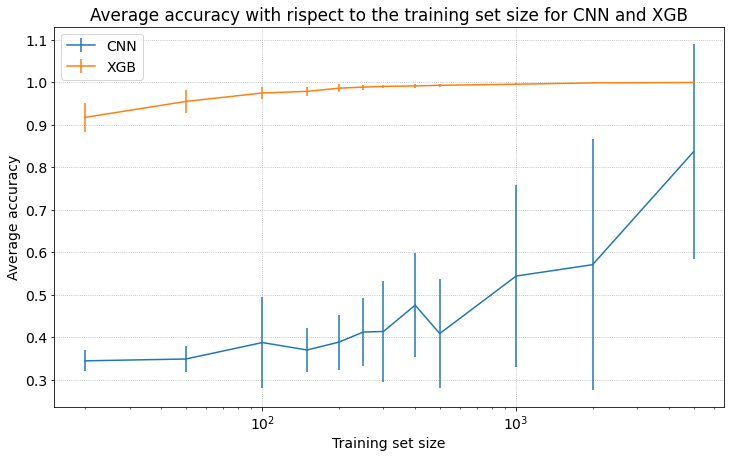

In [16]:
CNN_avg = np.mean(accuracy_scores_CNN,axis = 0)
CNN_std = np.std(accuracy_scores_CNN,axis = 0)

XGB_avg = np.mean(accuracy_scores_XGB,axis = 0)
XGB_std = np.std(accuracy_scores_XGB,axis = 0)

fig, ax = plt.subplots( figsize = ( 12, 7 ) )

ax.errorbar(Ns,y = CNN_avg, yerr= CNN_std , label = "CNN")
ax.errorbar(Ns,y = XGB_avg, yerr= XGB_std , label = "XGB")
plt.xscale("log")

ax.set_title( 'Average accuracy with rispect to the training set size for CNN and XGB' )
ax.set_xlabel( 'Training set size' )
ax.set_ylabel( 'Average accuracy' )
ax.grid( linestyle = 'dotted' )
ax.legend( loc = 'upper left' )


plt.show()

# fix the layout: add grid, add labels and title, add a 

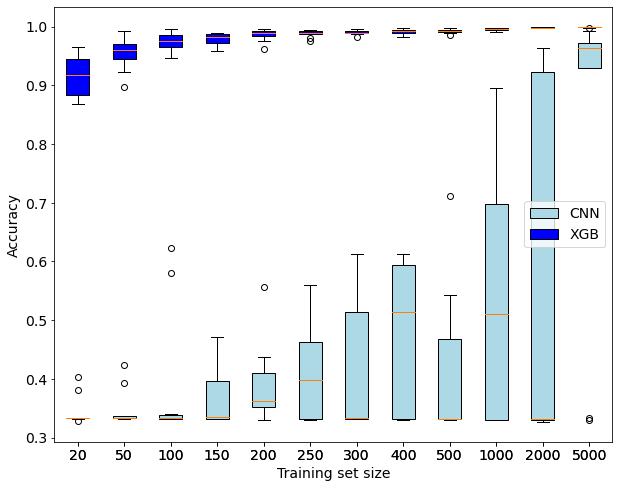

In [23]:
fig,axs = plt.subplots(1,1,figsize = (10,8))

box_CNN = axs.boxplot(accuracy_scores_CNN,
    labels = Ns,
    patch_artist= True,
    )
for patch in box_CNN['boxes']:
    patch.set_facecolor("lightblue")

box_XGB = axs.boxplot(accuracy_scores_XGB,
    labels = Ns,
    patch_artist= True,
    )
for patch in box_XGB['boxes']:
    patch.set_facecolor("blue")

axs.set_xlabel( 'Training set size' )
axs.set_ylabel( 'Accuracy' )
axs.legend([box_CNN["boxes"][0], box_XGB["boxes"][0]], ['CNN', 'XGB'], loc = 'best' )
plt.show()


## Task 1.b Most relevant features for XGBoost

------------- Feature importance sum = 0.99999994
------------- Showing feature with importance > 0.005
1 value__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8 0.47116125
2 value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0 0.23324922
3 value__cid_ce__normalize_False 0.15908161
4 value__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6 0.035173558
5 value__change_quantiles__f_agg_"var"__isabs_False__qh_0.2__ql_0.0 0.021339703
6 value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0 0.01579993
7 value__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8 0.010225826
8 value__autocorrelation__lag_2 0.0083253775
9 value__last_location_of_maximum 0.0058508306


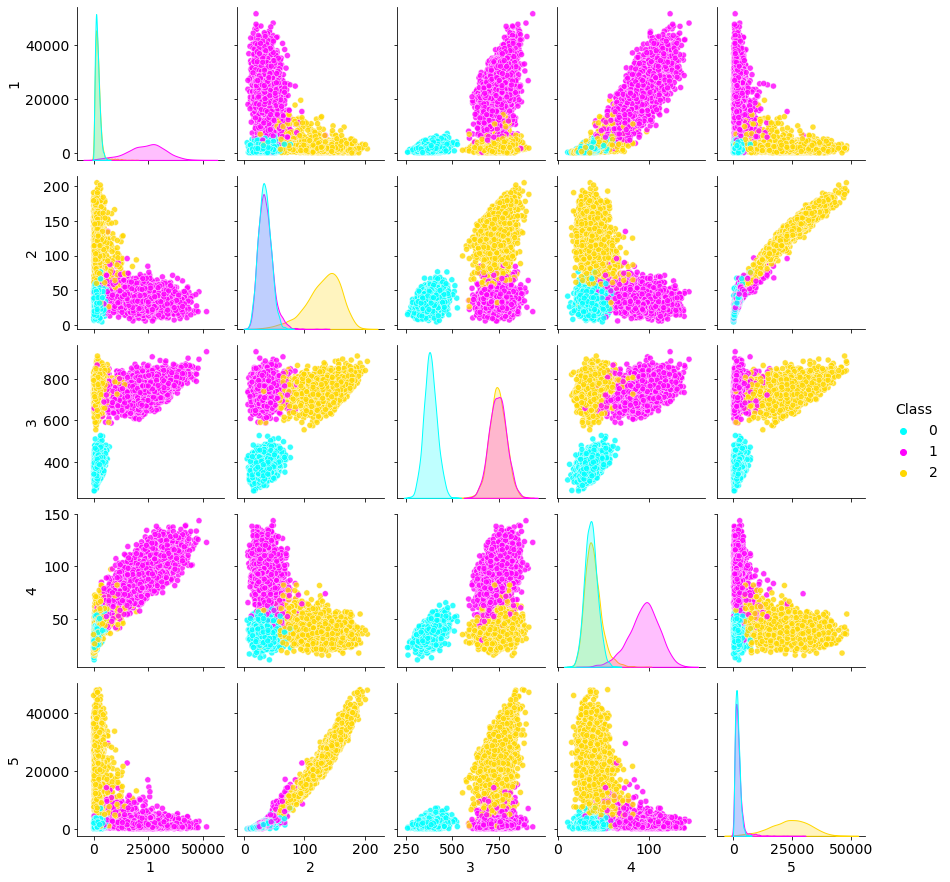

In [46]:
#get feature names
feature_names = x_features.columns.values

#empty dict
feat_imp = {}
#get f importance from model
for i,f in enumerate(feature_names):
    feat_imp[f] = XGB_model.feature_importances_[i]
#sort features depending on their importances
feat_imp = dict(sorted(feat_imp.items(), reverse=True, key=lambda item: item[1]))

minval=0.005
print('------------- Feature importance sum = '+str(np.sum(XGB_model.feature_importances_)))
print('------------- Showing feature with importance > '+str(minval))
for i,k in enumerate(feat_imp.keys()):
    if feat_imp[k]>minval: print(i+1,k,feat_imp[k])


# get feature names given importance order
features = list(feat_imp.keys())
#print(features)


# build dataframe for sns pairplot
df = pd.DataFrame({'1':x_features[features[0]],\
                   '2':x_features[features[1]],\
                   '3':x_features[features[2]],\
                   '4':x_features[features[3]],\
                   '5':x_features[features[4]],\
                   'Class':np.argmax(y,axis = 1)})
# pairplot with seaborn
pal = sns.blend_palette(["cyan","magenta","gold"],n_class)
sns.pairplot(df,hue='Class',plot_kws=dict(alpha=0.8),palette=pal);


Description of the features:

- 1 : This gives the variance of the data that is within the quantiles form 0.8 to 1.0 of the data values.
- 2 : This gives the mean of the data that is within the quantiles form 0.0 to 0.2 of the data values.
- 3 : Cid_ce - Estimate the complexity of the time series, it it the root of sum of square of nearest neighbourh change.
- 4 : This gives the mean of the data that is within the quantiles form 0.0 to 0.2 of the data values.
- 5 : This gives the mean of the data that is within the quantiles form 0.6 to 1.0 of the data values.
- 6 : This gives the variance of the data that is within the quantiles form 0.0 to 0.2 of the data values.

Possible explanation:

Looking through the list we se that the 6 first terms consist of inherently three different types of features. Features 1 and 6 is the variance in the data for the highest and lowest 20% of the data respectively. This intuitively makes sense as the pattern would either make the low or high variance be larger than if there is no pattern. Features 2,4 and 5 is the mean of the highest and lowest 20 %, and 40% highest for 5. This also seemes to make sense as the lowest and highest values would tend to be larger when pattern is present and then in either direction. The feature 3 is a good indication to distinguish if there is a pattern or not, but not what type as sign is lost since it is squared. The features is expected to be bigger when a pattern is present and smaller when not. 

## Task 1.c Comparison FFNN vs XGBoost

OPTIONAL: with the features extracted by tsfresh, train a standard (non-convolutional) feed
forward neural network (FFNN) and compare the performances with those of XGBoost. Than
keep only the most relevant features from XGBoost and train another FFNN with this smaller
set (of features). Is the new FFNN working better than the one trained with all features?

In [123]:
def create_FFNNmodel(
    optimizer = "adam",
    hidden_layers = 4,
    number_of_nodes = 10,
    dropout = 0,
    activation = 'relu',
    weight_init = 'glorot_uniform',
    learning_rate = 0
    ):
    """
    returns a complied model with the given parameters
    
    Inputs
    ----------
    optimizer : optimizer passed when compiled default='adam'
    hidden_layers : number of hidden layers in the model default = 4
    num_nodes : number of nodes in the hidden layers default = 10
    dropout : dropout rate for the hidden layers default = 0
    activation : activation function in the hidden layers default = 'relu'
    weight_init : weight initialization in the hidden layers default = 'glorot_uniform'
    learning_rate : If set to a non-zero value this sets a Adam optimizer with this value
        default 0

    """
    # Create sequential model
    model = Sequential()
    # Input layer
    model.add(Dense(L, input_shape=(L,), activation = 'sigmoid'))
    # Loop over the hidden layers
    for i in range(hidden_layers):
        model.add(
            Dense(
            number_of_nodes,
            activation=activation,
            kernel_initializer=weight_init
            )
        )
        model.add(Dropout(dropout))
    
    # Output layer
    model.add(Dense(3, activation='softmax'))
    #model.add(Flatten())
    
    opt = tf.keras.optimizers.Adam()

    model.compile(loss="categorical_crossentropy", optimizer= "adam", metrics=['accuracy'])

    return model

In [124]:
'''
N_check = 10
# Added some more samples than whats in the task to see when they where compariable
Ns = [20, 50, 100, 150, 200, 250, 300, 400, 500, 1000, 2000, 5000] 
N_validation = 5000 # Since we have a lot of samples

accuracy_scores_FFNN = np.zeros((N_check,len(Ns)))
accuracy_scores_XGB  = np.zeros((N_check,len(Ns)))

for n in tqdm(range(N_check)):
    for i,N in enumerate(Ns):
        FFNN_model = create_FFNNmodel()
        FFNN_model.summary()

        x_train,y_train,x_valid,y_valid = features_split(x,y,N_train=N, N_valid = N_validation )
        y_train = tf.keras.utils.to_categorical(y_train, num_classes=n_class)
        FFNN_model.fit(x_train,y_train,verbose=0,epochs=EPOCHS,batch_size= BATCH_SIZE)

        y_pred_valid = FFNN_model.predict(x_valid)
        
        #print(np.argmax(y_pred_valid,axis = 1))
        accuracy_scores_FFNN[n,i] = accuracy_score(y_valid, np.argmax(y_pred_valid,axis = 1))

        XGB_model = create_XGTBoostmodel(set_seed = False)
        x_train,y_train,x_valid,y_valid = features_split(x_features.values,y,N_train=N)
        XGB_model.fit(x_train,y_train,verbose=0)

        y_pred_val = XGB_model.predict(x_valid)
        accuracy_scores_XGB[n,i] = accuracy_score(y_valid,y_pred_val)
'''

'\nN_check = 10\n# Added some more samples than whats in the task to see when they where compariable\nNs = [20, 50, 100, 150, 200, 250, 300, 400, 500, 1000, 2000, 5000] \nN_validation = 5000 # Since we have a lot of samples\n\naccuracy_scores_FFNN = np.zeros((N_check,len(Ns)))\naccuracy_scores_XGB  = np.zeros((N_check,len(Ns)))\n\nfor n in tqdm(range(N_check)):\n    for i,N in enumerate(Ns):\n        FFNN_model = create_FFNNmodel()\n        FFNN_model.summary()\n\n        x_train,y_train,x_valid,y_valid = features_split(x,y,N_train=N, N_valid = N_validation )\n        y_train = tf.keras.utils.to_categorical(y_train, num_classes=n_class)\n        FFNN_model.fit(x_train,y_train,verbose=0,epochs=EPOCHS,batch_size= BATCH_SIZE)\n\n        y_pred_valid = FFNN_model.predict(x_valid)\n        \n        #print(np.argmax(y_pred_valid,axis = 1))\n        accuracy_scores_FFNN[n,i] = accuracy_score(y_valid, np.argmax(y_pred_valid,axis = 1))\n\n        XGB_model = create_XGTBoostmodel(set_seed = Fal

## Task 2, 2D Classification of non-linear function

In [88]:
L = 2
N_TRAIN = 4000
N_VALID = 4000

def rescale(x,x_ref,RTYPE = 2):
    """
    Returns a copy of the x-data rescale acording to TYPE with x_ref as
    the reference date to scale wrt.

    Inputs
    ----------
    x : data array of d
    x : data array that the rescaling is done wrt.
    RTYPE : determines what type of rescaling is used
        - 0 - do nothing
        - 1 - normalize based on max and min of x_ref
        - 2 - standarize based on avg and std of x_ref (default)
    """
    # Create output
    x_out = np.zeros(x.shape)
    
    # Check what type to use
    if RTYPE == 0:
        x_out = np.copy(x)
        return x_out
    
    if RTYPE == 1:
        # normalization, for each dimension
        for i in range(L):
            x_out[:,i] = (x[:,i]-np.max(x_ref[:,i]))/(-np.max(x_ref[:,i])+np.min(x_ref[:,i]))*2-1
        return x_out
    
    if RTYPE == 2:
        # standardization, for each dimension
        for i in range(L):
            x_out[:,i] = (x[:,i]-np.mean(x_ref[:,i]))/(np.std(x_ref[:,i]))
        return x_out


def non_linear_func(x ,TYPE = 0):
    """
    returns labels of x, uses the non-linear function determined
    by TYPE
    
    inputs
    ----------
    x : data array
    TYPE : determines func used
        - 0 : triangle
        - 1 : circle
        - 2 : sine
        - 3 : sine, but flip for x_0 > 0
        - 4 : Smiley face
    """
    # Create output array
    r= np.zeros(x.shape[0])
    
    # Check what type
    if TYPE == 0:
        # Triangle
        for i,x_i in enumerate(x):
            r[i] = x_i[0]>-20 and x_i[1]>-40 and x_i[0]+x_i[1] < 40
        
    if TYPE == 1:
        # Circle
        for i,x_i in enumerate(x):
            r[i] = x_i[0]*x_i[0] + x_i[1]*x_i[1] < 30*30
    
    if TYPE == 2:
        # Sine
        for i,x_i in enumerate(x):
            r[i] = x_i[1] > np.sin(2*np.pi/100 *(x_i[0]-50))*25
            
    if TYPE == 3:
        # Sine, flips halfway
        for i,x_i in enumerate(x):
            if x_i[0] < 0:
                r[i] = x_i[1] > np.sin(2*np.pi/100 *(x_i[0]-50))*25
            else:
                r[i] = x_i[1] < np.sin(2*np.pi/100 *(x_i[0]-50))*25
    
    if TYPE == 4:
        # Smiley face
        for i,x_i in enumerate(x):
            if (x_i[0]+25)**2 + (x_i[1]-25)**2 < 15**2:
                r[i]=1
            elif (x_i[0]-25)**2 + (x_i[1]-25)**2 < 15**2:
                r[i] = 1
            elif (x_i[0])**2 + (x_i[1]-15)**2 < 8**2:
                r[i] = 1
            
            if (x_i[0])**2 + (x_i[1]+10)**2 < 35**2 and x_i[1] < -10:
                r[i] = 1
            if (x_i[0])**2 + (x_i[1]+18)**2 < 20**2 and x_i[1] < -18:
                r[i] = 0 
    return r

def create_datapoints(N=4000,L=L,B=100,TYPE = 0):
    """
    Creates datapoints and returns x,y, where y is the labels
    given by the non-linear function of TYPE

    Inputs
    ----------
    N : number of datapoints, default 4000
    L : size of each sample, default 2
    B : box size, default 100
    TYPE : type of labeling, passed to non_linear_func

    Outputs
    ---------
    x : np.array of shape (N,L) with data, NOT RESCALED
    y : np.array of shape (N,) with labels from non_linear_func
    """
    x = (np.random.random((N,L))-0.5)*B
    y = non_linear_func(x,TYPE = TYPE)
    return x,y

def create_datasets(N_train=N_TRAIN,N_valid = N_VALID,L=L,B=100,TYPE = 0,RTYPE = 2):
    """
    Creates datapoints and returns data sets for training and validation already rescaled

    Inputs
    ----------
    N_test : number of test datapoints, default 3200
    N_valid : number of validation datapoints, default 800
    L : size of each sample, default 2
    B : box size, default 100
    TYPE : type of labeling, passed to non_linear_func
    RTYPE : type of rescaling, passed to rescale

    Outputs
    ---------
    x_train,y_train,x_valid,y_valid

    """
    x,y = create_datapoints(N= N_valid+N_train,L=L,B=B,TYPE=TYPE)

    x_train, y_train =rescale(x[:N_train],x[:N_train],RTYPE=RTYPE) ,y[:N_train]
    x_valid, y_valid =rescale(x[N_train:],x[:N_train],RTYPE=RTYPE), y[N_train:]
    
    return x_train,y_train,x_valid,y_valid


In [13]:
learning_rates = [0.2, 0.3, 0.4]
gammas = [0, 0.1 , 1]
max_depths = [1,2,4, 6, 8]
min_child_weights = [0, 1, 10]
max_delta_steps = [0, 1, 10]
subsampless = [0,0.5]
reg_lambdas = [0.1,1,10]
n_estimatorss = [1,10,100]

x_train,y_train, x_valid, y_valid = create_datasets(N_train=1000,N_valid= 4000)

for n_estimators in n_estimatorss:
    XGB_model = create_XGTBoostmodel(
        n_estimators = n_estimators
        )
    XGB_model.fit(x_train,y_train)


    y_valid_predict = XGB_model.predict(x_valid)
    accuracy = accuracy_score(y_valid,y_valid_predict)
    print(f"n_estimators:{n_estimators}, acc: {accuracy}")

n_estimators:1, acc: 0.97375
n_estimators:10, acc: 0.9835
n_estimators:100, acc: 0.98325


'\nanim = FuncAnimation(fig, \n    lambda frame: animate(frame,\n        max_depth = frame,\n        n_estimators = 20,\n        gamma = 1,\n        learning_rate = 0.1,\n        ),\n    frames = 10,\n    interval = 500)\n\nplt.close()\ndisplay.HTML(anim.to_jshtml())\n'

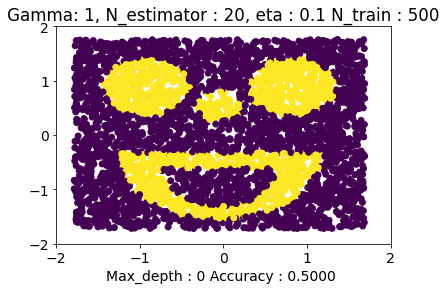

In [60]:
from matplotlib.animation import FuncAnimation
from IPython import display


# Not included the animations in the final so run them localy to show them, did not upload to git hub with them

x_train,y_train, x_valid,y_valid = create_datasets(N_train=500, N_valid= 4000,TYPE = 4)

def animate(frame,**kwargs):
    XGB_model = create_XGTBoostmodel(
        **kwargs
        )

    XGB_model.fit(x_train,y_train)

    y_valid_predict = XGB_model.predict(x_valid)

    scatter.set_array(y_valid_predict)
    accuracy = accuracy_score(y_valid,y_valid_predict)
    
    ax.set_xlabel(f"Max_depth : {frame} Accuracy : {round(accuracy,4)}")
    


fig,ax = plt.subplots()
ax.set_title("Gamma: 1, N_estimator : 20, eta : 0.1 N_train : 500")
plt.xlim(-2,2)
plt.ylim(-2,2)
ax.set_xlabel(f"Max_depth : {0} Accuracy : 0.5000 ")
scatter = ax.scatter(x_valid[:,0],x_valid[:,1],c = y_valid)

# Uncoment these lines
"""
anim = FuncAnimation(fig, 
    lambda frame: animate(frame,
        max_depth = frame,
        n_estimators = 20,
        gamma = 1,
        learning_rate = 0.1,
        ),
    frames = 10,
    interval = 500)

plt.close()
display.HTML(anim.to_jshtml())
"""

'\nanim = FuncAnimation(fig, \n    lambda frame: animate(frame,\n        max_depth = frame,\n        n_estimators = 1,\n        gamma = 1,\n        learning_rate = 0.1,\n        ),\n    frames = 20,\n    interval = 300)\n# anim.save(f"max_depthTYPE4.gif")\nplt.close()\ndisplay.HTML(anim.to_jshtml())\n'

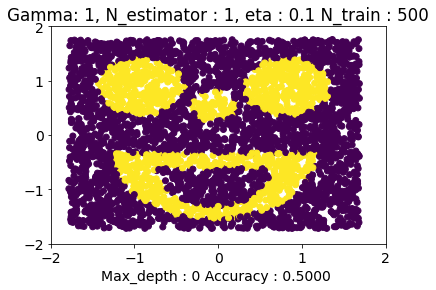

In [61]:
fig,ax = plt.subplots()
ax.set_title("Gamma: 1, N_estimator : 1, eta : 0.1 N_train : 500")
plt.xlim(-2,2)
plt.ylim(-2,2)
ax.set_xlabel(f"Max_depth : {0} Accuracy : 0.5000 ")
scatter = ax.scatter(x_valid[:,0],x_valid[:,1],c = y_valid)

"""
anim = FuncAnimation(fig, 
    lambda frame: animate(frame,
        max_depth = frame,
        n_estimators = 1,
        gamma = 1,
        learning_rate = 0.1,
        ),
    frames = 20,
    interval = 300)
# anim.save(f"max_depthTYPE4.gif")
plt.close()
display.HTML(anim.to_jshtml())
"""

'\nanim = FuncAnimation(fig, \n    lambda frame: animate(frame,\n        max_depth = frame,\n        n_estimators = 2,\n        gamma = 1,\n        learning_rate = 0.1,\n        ),\n    frames = 15,\n    interval = 300)\n# anim.save(f"max_depthTYPE4.gif")\nplt.close()\ndisplay.HTML(anim.to_jshtml())\n'

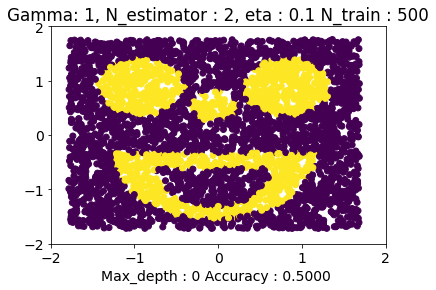

In [62]:
fig,ax = plt.subplots()
ax.set_title("Gamma: 1, N_estimator : 2, eta : 0.1 N_train : 500")
plt.xlim(-2,2)
plt.ylim(-2,2)
ax.set_xlabel(f"Max_depth : {0} Accuracy : 0.5000 ")
scatter = ax.scatter(x_valid[:,0],x_valid[:,1],c = y_valid)

"""
anim = FuncAnimation(fig, 
    lambda frame: animate(frame,
        max_depth = frame,
        n_estimators = 2,
        gamma = 1,
        learning_rate = 0.1,
        ),
    frames = 15,
    interval = 300)
# anim.save(f"max_depthTYPE4.gif")
plt.close()
display.HTML(anim.to_jshtml())
"""

'\nanim = FuncAnimation(fig, \n    lambda frame: animate(frame,\n        max_depth = 4,\n        n_estimators = frame,\n        gamma = 1,\n        learning_rate = 0.1,\n        ),\n    frames = 51,\n    interval = 50)\n# anim.save(f"max_depthTYPE4.gif")\nplt.close()\ndisplay.HTML(anim.to_jshtml())\n'

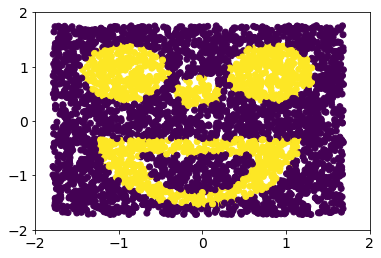

In [63]:
fig,ax = plt.subplots()
plt.xlim(-2,2)
plt.ylim(-2,2)
# ax.set_xlabel(f"Max_depth : {0} Accuracy : 0.5000 ")
graph = ax.scatter(x_valid[:,0],x_valid[:,1],c = y_valid)


x_train,y_train, x_valid,y_valid = create_datasets(N_train=1000, N_valid= 4000,TYPE = 4)

def animate(frame,**kwargs):
    XGB_model = create_XGTBoostmodel(
        **kwargs
        )

    XGB_model.fit(x_train,y_train)

    y_valid_predict = XGB_model.predict(x_valid)

    accuracy = accuracy_score(y_valid,y_valid_predict)
    graph.set_array(y_valid_predict)
    # ax.scatter(x_valid[:,0],x_valid[:,1],c = y_valid_predict)
    ax.set_xlabel(f"N_estimators : {frame} Accuracy : {round(accuracy,4)}")
    plt.tight_layout()
"""
anim = FuncAnimation(fig, 
    lambda frame: animate(frame,
        max_depth = 4,
        n_estimators = frame,
        gamma = 1,
        learning_rate = 0.1,
        ),
    frames = 51,
    interval = 50)
# anim.save(f"max_depthTYPE4.gif")
plt.close()
display.HTML(anim.to_jshtml())
"""